Inferenza per via analitica del parametro $p$ di una distribuzione di Bernoulli.

In [126]:
%matplotlib inline
import sys
import numpy as np
import scipy.stats as st
from scipy.optimize import fmin
from scipy.special import beta as beta_func
import matplotlib.pyplot as plt

Configurazione per grafica

In [127]:
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['lines.linewidth'] = 2

Funzione che determina l'intervallo contenente probabilità credMass per la distribuzione data

In [25]:
def HDIofICDF(dist_name, credMass=0.95, **args):
    # freeze distribution with given arguments
    distri = dist_name(**args)
    # initial guess for HDIlowTailPr
    incredMass =  1.0 - credMass

    def intervalWidth(lowTailPr):
        return distri.ppf(credMass + lowTailPr) - distri.ppf(lowTailPr)

    # find lowTailPr that minimizes intervalWidth
    HDIlowTailPr = fmin(intervalWidth, incredMass, ftol=1e-8, disp=False)[0]
    # return interval as array([low, high])
    return distri.ppf([HDIlowTailPr, credMass + HDIlowTailPr])

La distribuzione prior è una Beta con parametri $\alpha$ e $\beta$

In [8]:
alpha = 5
beta = 10

Genera sequenza di $n$ osservazioni $0/1$ mediante lanci con probabilità di $1$ pari a $p$

In [128]:
# numero osservazioni
n = 1000
# probabilità di 1
p = .65
np.random.seed()
data = np.random.choice(a=(1, 0), p=(p, 1-p), size=n, replace=True)

Conta numero di osservazioni totali e numero di osservazioni $1$ 

In [129]:
n = len(data)
z = sum(data[data == 1])

La distribuzione a posteriori è una beta anch'essa. Calcola i parametri relativi

In [130]:
alpha_p = alpha+z
beta_p = beta+n-z

Calcola l'evidenza dell'insieme di osservazioni (probabilità di occorrenza, dato il modello)

In [131]:
evidence = beta_func(alpha_p, beta_p)/beta_func(alpha, beta)

Definiamo una griglia di valori per theta

In [132]:
bin_width = 0.005
theta = np.arange(bin_width/2, 1-(bin_width/2)+bin_width, bin_width)

Calcola prior, likelihood e posterior per ogni valore della griglia

In [133]:
prior_theta = st.beta.pdf(theta, alpha, beta)
likelihood_theta = theta**z * (1-theta)**(n-z)
posterior_theta = st.beta.pdf(theta, alpha_p, beta_p)

Calcola intervallo contenente il $95\%$ di probabilità della posterior

In [134]:
 intervals = HDIofICDF(st.beta, .95, a=alpha_p, b=beta_p)

Calcola il massimo (approssimato) della distribuzione a posteriori

In [135]:
MAP = theta[np.argmax(posterior_theta)]

Plot delle distribuzioni

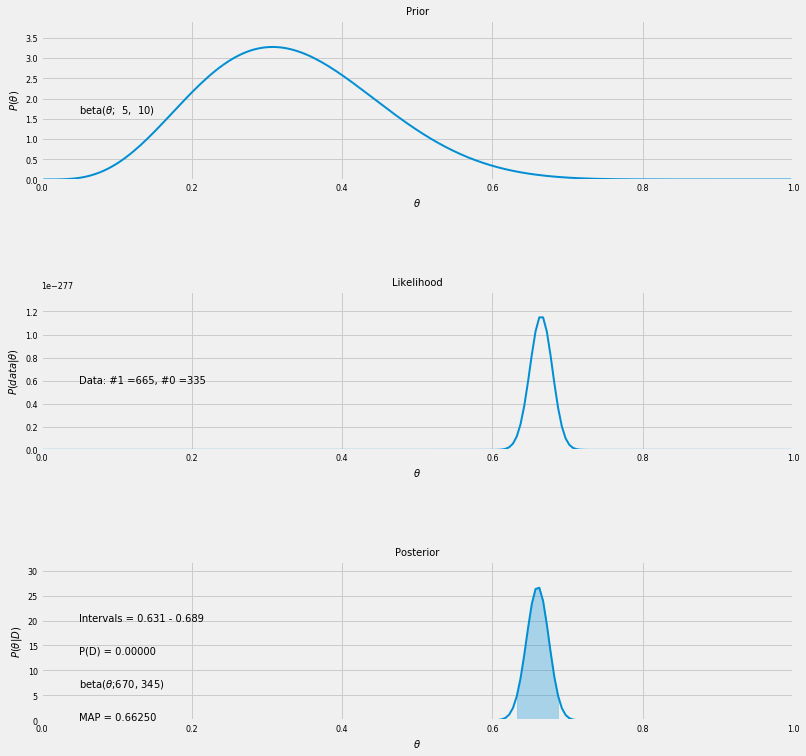

In [136]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.subplots_adjust(hspace=0.7)
# Plot del prior.
locx = 0.05
plt.subplot(3, 1, 1)
plt.plot(theta, prior_theta)
plt.xlim(0, 1)
plt.ylim(0, np.max(prior_theta)*1.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
plt.title('Prior')
plt.text(locx, np.max(prior_theta)/2, r'beta($\theta$;{0:3d}, {1:3d})'.format(alpha, beta))
    
# Plot della likelihood
plt.subplot(3, 1, 2)
plt.plot(theta, likelihood_theta)
plt.xlim(0, 1)
plt.ylim(0, np.max( likelihood_theta)*1.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(data|\theta)$')
plt.title('Likelihood')
plt.text(locx, np.max( likelihood_theta)/2, 'Data: #1 ={0:3d}, #0 ={1:3d}'.format(z, n-z))
    
# Plot della posterior
plt.subplot(3, 1, 3)
plt.plot(theta, posterior_theta)
plt.xlim(0, 1)
plt.ylim(0, np.max(posterior_theta)*1.2)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta|D)$')
plt.title('Posterior')
locy = np.linspace(0, np.max(posterior_theta), 5)
plt.text(locx, locy[1], r'beta($\theta$;{0:3d}, {1:3d})'.format(alpha_p, beta_p))
plt.text(locx, locy[2], 'P(D) = {0:.5f}'.format(evidence))
plt.text(locx, locy[0], 'MAP = {0:.5f}'.format(MAP))
    
# Plot dell'ntervallo al 95%
plt.text(locx, locy[3], 'Intervals = {0:.3f} - {1:.3f}'.format(intervals[0], intervals[1]))
plt.fill_between(theta, 0, posterior_theta, where=np.logical_and(theta > intervals[0],
                theta < intervals[1]), color='C0', alpha=0.3)